## Multi-label hotel room name classification

In [118]:
# uncomment the following if the environment is missing any of the dependencies
# !pip install tensorflow-hub
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn

In [122]:
from __future__ import absolute_import, division, print_function

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import datetime, os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.13.1
Eager mode:  False
Hub version:  0.4.0
GPU is NOT AVAILABLE


### Step 1. Loading the dataset

We need to load the dataset used by this project

1. Define the functions used to load the csv data

In [123]:
def load_project_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="source_data_labeled.zip", 
      origin="https://github.com/x-wing/room-classify/raw/master/source_data_labeled.zip", 
      cache_subdir='data',
      extract=True,
      cache_dir="./")
  
  df_data = \
     pd.read_csv(dataset, usecols=['hotel id', 'room_name','labels'], \
                 dtype= { "hotel_id":np.uint8, "room_name": np.character,'labels':np.character})

  return df_data

def split_datasets(data, test_size=0.2):
    return train_test_split(data, test_size, shuffle=true)

def split_datasets_with_labels(x, y, t_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=t_size, shuffle=True)
    return x_train, x_test, y_train, y_test


2. Invoke the functoin to load the source dataset from github repo
3. Use a sample 10% (143207 records) of the whole dataset to reduce the time to run the overall project. It could take hours to finish one epoch if go with the whole dataset

In [124]:
data_df = load_project_datasets()
data_df = data_df.sample(frac=0.10)
data_df.head()

,hotel id,room_name,labels
317119,162,Premier Club Suite-King Bed,bdc_1 bdt_king rmt_suite rmt_premium rtf_free_...
1295600,190,"Deluxe Double Room,1 Double Bed,Accessible,Smo...",rmf_smoking prmf_free_breakfast rmf_free_inter...
1064779,125,"Suite,1 King Bed,Non Smoking,Kitchen Continent...",rmf_no_smoking prmf_free_breakfast bdc_1 bdt_k...
512499,121,2 Queen Beds Family Suite Non-Smoking NRF,rmf_no_smoking rtf_nrf bdc_2 bdt_queen rmt_sui...
7371,34,"Standard Room,2 Queen Beds,Non Smoking Free Br...",rmf_no_smoking prmf_free_breakfast rmf_free_in...


In [125]:
data_df.shape

(143207, 3)

### Step 2. Data preparation

We need to use the loaded dataset to extract labels to be used for the project

1. Find all the labels

In [126]:
from collections import Counter
number_of_class = 10
top_labels = Counter(" ".join(data_df["labels"]).split()).most_common(number_of_class)
labels_dict = dict(top_labels)
labels = labels_dict.keys()

2. Update and run the following if need to specify labels to be used or skip this step to use default top 10 labels

In [127]:
selected_labels = [ 
    'rmt_title', 'rmt_suite', 'rmt_standard', 'rmt_deluxe','rmt_bedroom','rmt_studio','rmt_superior','rmt_apartment','rmt_triple','rmt_premium','rmt_quadruple','rmt_villa','rmt_bungalow','rmt_cottage','rmt_single','rmt_dorm',
    'rmt_cabin', 'rmt_grand', 'rmt_mini', 'rmt_non_suite', 'rmt_parlor', 'rmt_penthouse', 'rmt_pod', 'rmt_residence', 'rmt_room', 'rmt_twin',
    'bdt_king', 'bdt_double', 'bdt_queen', 'bdt_twin','bdt_single','bdt_full',
    'bdc_more', 'rmc_more',
    'prmf_free_breakfast','prmf_half_board','prmf_welcome_item','prmf_all_inclusive','prmf_full_board','prmf_free_dinner',
    'rtf_other_item_or_credit_included','rtf_fee_included','rtf_free_parking',
    'rmf_no_smoking','rmf_accessible','rmf_extra_bedding','rmf_smoking','rmf_balcony','rmf_terrace',
    'rmv_good','rmv_better','rmv_standard','rmv_best','rmv_non']

use_selected_labels = True

In [128]:
print(list(labels))

['rtf_free_transport', 'rmt_room', 'bdc_1', 'rtf_nrf', 'rmf_free_internet', 'prmf_free_breakfast', 'rmf_no_smoking', 'rmt_title', 'bdt_king', 'rmt_suite']


In [129]:
if use_selected_labels==True:
    active_labels = selected_labels
    number_of_class = len(selected_labels)
else:
    active_labels = list(labels)

3. Split the input data into training and testing sets

In [130]:
data_label_df = data_df["labels"].str.split()
x_train, x_test, y_train, y_test = split_datasets_with_labels(data_df, data_label_df, 0.25)

In [131]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(107405, 3) (35802, 3) (107405,) (35802,)


In [132]:
x_train['room_name'].head(10)

835732     1 Queen Bed Suite Non-Smoking - Free Internet ...
37578      Standard Room,2 Queen Beds Continental Breakfa...
445224                                         2 Queen Beds 
460493     1 Queen Mobility Hearing Accessible Tub Sofabe...
465392     Executive Room - Free Internet In Room - Free ...
1382120    Double or Twin Room,2 Twin Free Breakfast,Free...
277144     Standard Room,1 King Bed Continental Breakfast...
1131946    Deluxe Room,2 Twin Beds Free Breakfast,Free Pa...
646214     Standard Room,1 King Bed Continental Breakfast...
1107994    Double Room,Garden View Free Breakfast,Free In...
Name: room_name, dtype: object

4. Use MultiLabelBinarizer to encode labels into zeros and ones

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

encoder = MultiLabelBinarizer(active_labels)
encoder.fit_transform(y_train)
train_encoded = encoder.transform(y_train)
test_encoded = encoder.transform(y_test)
num_classes = len(encoder.classes_)

# Print all possible genres and the labels for the first movie in our training dataset
# print(encoder.classes_)
# print(train_encoded[0])

5. change encoded labels into string type as required by the model later on

In [134]:
train_encoded_f = train_encoded.astype(np.str)
test_encoded_f = test_encoded.astype(np.str)

### Step 3. Model setup

Next, we need to specify tfhub module for encoding. Our final choice is universal-sentence-encoder (See in [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/2))

1. Create hub module
2. Define embeding function to be used in Lambda express for input processing
3. Create keras model
4. Compile model with an optimizer (use tf.train.AdamOptimizer or tf.keras.optimizers.Adam), loss function, metrics


In [135]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url, trainable=False)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

# Example: uncomment to see the results of the embedding
# embeddings = embed([
#     "King Accessible Tub Sofabed Non-Smoking - Free Internet In Room - Free Parking NRF",
#     "Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit"])

# with tf.Session() as session:
#   session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#   message_embeddings = session.run(embed(messages))
# print(message_embeddings)

512

In [106]:
def embedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [114]:
input_text = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
hub_layer = tf.keras.layers.Lambda(embedding, output_shape=(embed_size,))(input_text)
dense = tf.keras.layers.Dense(256, activation='relu')(hub_layer)
pred = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=[input_text], outputs=pred)

# prefer this way but can't get it to work with this particular way of input
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(embed_size, input_shape=(1,)))
# model.add(tf.keras.layers.Lambda(lambda x: UniversalEmbedding(x), output_shape=(embed_size,)))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0421 20:28:42.667616 11376 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 54)                13878     
Total params: 145,206
Trainable params: 145,206
Non-trainable params: 0
_________________________________________________________________


In [115]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'binary_accuracy' categorical_accuracy
# adam = tf.keras.optimizers.Adam(lr=0.05, beta_1=0.99, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
adam =tf.train.AdamOptimizer(learning_rate=0.003, beta1=0.99, beta2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy','binary_accuracy'])

### Step 4. Run Model

Here, we can run the model by loading previous weights with specified epochs and batch size. If need to save the model or the weights for the run, please uncomment the corresponding lines.

In [ ]:
with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_encoder_a.model')
  history = model.fit(x_train['room_name'].values, 
            train_encoded_f,
            validation_data=(x_test['room_name'].values, test_encoded_f),
            epochs=50,
            batch_size=128)
  
  results = model.evaluate(x_test['room_name'].values, test_encoded_f)

#   model.save_weights('./model_encoder_a.model')
#   model.save('model_encoder.h5')  


In [23]:
# print(logdir)
# !rm -rf ./tmp
print(results)

In [67]:
# show the history keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'binary_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_binary_accuracy'])

### Step 4. Model results

1. Training and validation loss


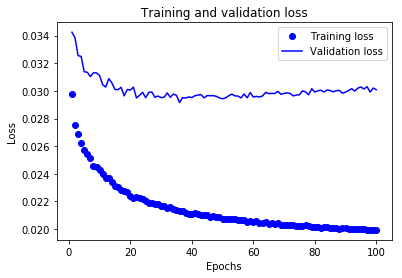

In [68]:
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. Training and validation acccuracy

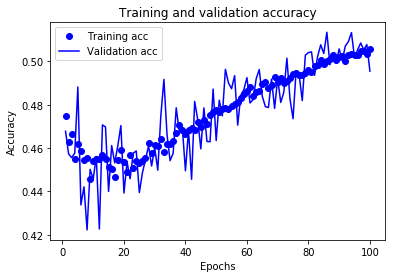

In [69]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3. Load and run saved model to ROC curve for first 3 classes 

In [83]:
# del model
with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model = tf.keras.models.load_model('model_encoder.h5')
  y_pred = model.predict(x_test['room_name'].values)

In [109]:
y_score = y_pred > 0.50
y_score = y_score.astype(np.int)

In [110]:
y_test = test_encoded_f=='1'
y_test = y_test.astype(np.int)

In [111]:
y_score[:,1]

array([0, 0, 0, ..., 1, 0, 0])

In [112]:
y_test[:,1]

array([0, 0, 0, ..., 1, 0, 0])

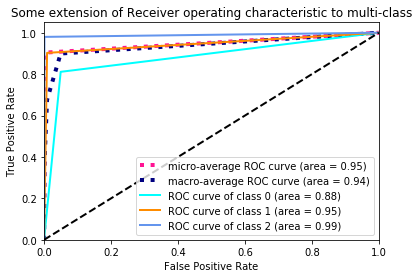

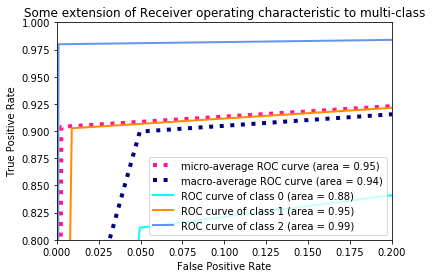

In [113]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

5. Show the model prediction in action with some example data entries

In [48]:
# To save model
# model.save('my_tf5_model.h5')

In [97]:
# raw_test = [
#     "King Accessible Tub Sofabed Non-Smoking - Free Internet In Room - Free Parking NRF", # King
#     "Deluxe Villa,6 Bedrooms,River View,Garden Area Free Parking,Free Wireless Internet,NRF", # Deluxe Villa
#     "Superior Double with Balcony NRF", # Superior, Double
#     "Wonderful King Ocean Front - Free Airport Shuttle - Non-Refundable", # King
#     "Room,1 King Bed with Sofa bed,Non Smoking,Refrigerator & Microwave,1 Full"
# ]

raw_test = [
"Deluxe Room, 2 Double Beds, Smoking",
"Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View",                 
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, High Roller View", 
"Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, Non Smoking",        
"Deluxe Room, 2 Queen Beds, Non Smoking Food/Beverage Credit",
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View",              
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, High Roller View",
"Deluxe Room, 2 Queen Beds, High Roller View Food/Beverage Credit",
"Luxury Room, 1 King Bed, Non Smoking",         
"Luxury Room, 1 King Bed, Non Smoking Food/Beverage Credit",
"Luxury Room, 2 Double Beds, Non Smoking",                
"Luxury Room, 2 Double Beds, Non Smoking Food/Beverage Credit",
"Suite, 1 King Bed, Non Smoking",             
"Deluxe Bungalow, 1 King Bed, Non Smoking, Poolside",
"Deluxe Poolside Cabana, 2 Doubles, Non-Smoking"
]


In [ ]:
# predict_input_fn = tf.estimator.inputs.numpy_input_fn({"room_name": np.array(raw_test).astype(np.str)}, shuffle=False)
results = model.predict(np.array(raw_test))

In [98]:
# del model
with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model = tf.keras.models.load_model('model_encoder.h5')
  results = model.predict(np.array(raw_test))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0421 19:47:40.970900 11376 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [103]:
for i in range(num_classes): 
    print(' ' + encoder.classes_[i], end=" ")  
print('')

counter=0
for room_features in results:
  print(raw_test[counter])
  label_index = 0
  for p in room_features:
    if p > 0.05 :
        print(encoder.classes_[label_index] + '=' + str(round(p * 100, 2)) + '%', end=" ")
    label_index += 1
  counter += 1
  print('\n')


 rmt_title  rmt_suite  rmt_standard  rmt_deluxe  rmt_bedroom  rmt_studio  rmt_superior  rmt_apartment  rmt_triple  rmt_premium  rmt_quadruple  rmt_villa  rmt_bungalow  rmt_cottage  rmt_single  rmt_dorm  rmt_cabin  rmt_grand  rmt_mini  rmt_non_suite  rmt_parlor  rmt_penthouse  rmt_pod  rmt_residence  rmt_room  rmt_twin  bdt_king  bdt_double  bdt_queen  bdt_twin  bdt_single  bdt_full  bdc_more  rmc_more  prmf_free_breakfast  prmf_half_board  prmf_welcome_item  prmf_all_inclusive  prmf_full_board  prmf_free_dinner  rtf_other_item_or_credit_included  rtf_fee_included  rtf_free_parking  rmf_no_smoking  rmf_accessible  rmf_extra_bedding  rmf_smoking  rmf_balcony  rmf_terrace  rmv_good  rmv_better  rmv_standard  rmv_best  rmv_non 
Deluxe Room, 2 Double Beds, Smoking
rmt_deluxe=100.0% rmt_room=100.0% bdt_double=99.91% rmf_smoking=30.51% 

Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit
rmt_title=99.22% rmt_deluxe=100.0% rmt_room=100.0% bdt_double=99.92% rmf_smoking=88.16% 

Deluxe Roo